# DINOv2 Background Remove Background - Multiple Test Images

**Test:** Does removing background improve object detection?

- **Reference:** `images/lambo_ref.png` (lambo with background manually removed)
- **Test Images:** 
  - `images/lambo.png` (same car type as reference)
  - `images/hero.jpg` (different car)
  - `images/jeep.jpg` (very different vehicle)

**Expected Results:**
- Lambo → Should work well (same object)
- Hero → Should work partially (similar car)
- Jeep → Should NOT work (different vehicle type)


In [ ]:
!python --version

: 

In [378]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [379]:
# Imports
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

_target_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {_target_device}")


Using device: cpu


In [380]:
# Load DINOv2
print("Loading DINOv2...")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg').eval().to(_target_device)

t_dinov2 = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Model loaded")


Loading DINOv2...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


✓ Model loaded


In [381]:
# Helper functions
def extract_global_feature(model, image_tensor, device="cuda"):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        return model(image_tensor)

def extract_patch_features(model, image_tensor, device="cuda"):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        features = model.forward_features(image_tensor)
        return features['x_norm_patchtokens']

def compute_similarity_map(global_feature, patch_features):
    global_norm = F.normalize(global_feature, p=2, dim=1)
    patch_norm = F.normalize(patch_features, p=2, dim=2)
    similarity = torch.matmul(patch_norm, global_norm.T).squeeze()
    return similarity.reshape(37, 37).cpu().numpy()

def upscale_mask(mask, target_size=(518, 518)):
    mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0)
    upscaled = F.interpolate(mask_tensor, size=target_size, mode='bilinear', align_corners=False)
    return upscaled.squeeze().numpy()

def apply_mask(image, mask, background_color=(0, 0, 0)):
    img_array = np.array(image)
    if mask.shape != img_array.shape[:2]:
        mask = np.array(Image.fromarray((mask * 255).astype(np.uint8)).resize(
            (img_array.shape[1], img_array.shape[0]), Image.BILINEAR)) / 255.0
    mask_3d = np.stack([mask] * 3, axis=2)
    background = np.ones_like(img_array) * background_color
    result = (img_array * mask_3d + background * (1 - mask_3d)).astype(np.uint8)
    return Image.fromarray(result)

print("✓ Functions loaded")


✓ Functions loaded


✓ Found images/lambo_ref.png
✓ Found images/lambo.png
✓ Found images/hero.jpg
✓ Found images/jeep.jpg


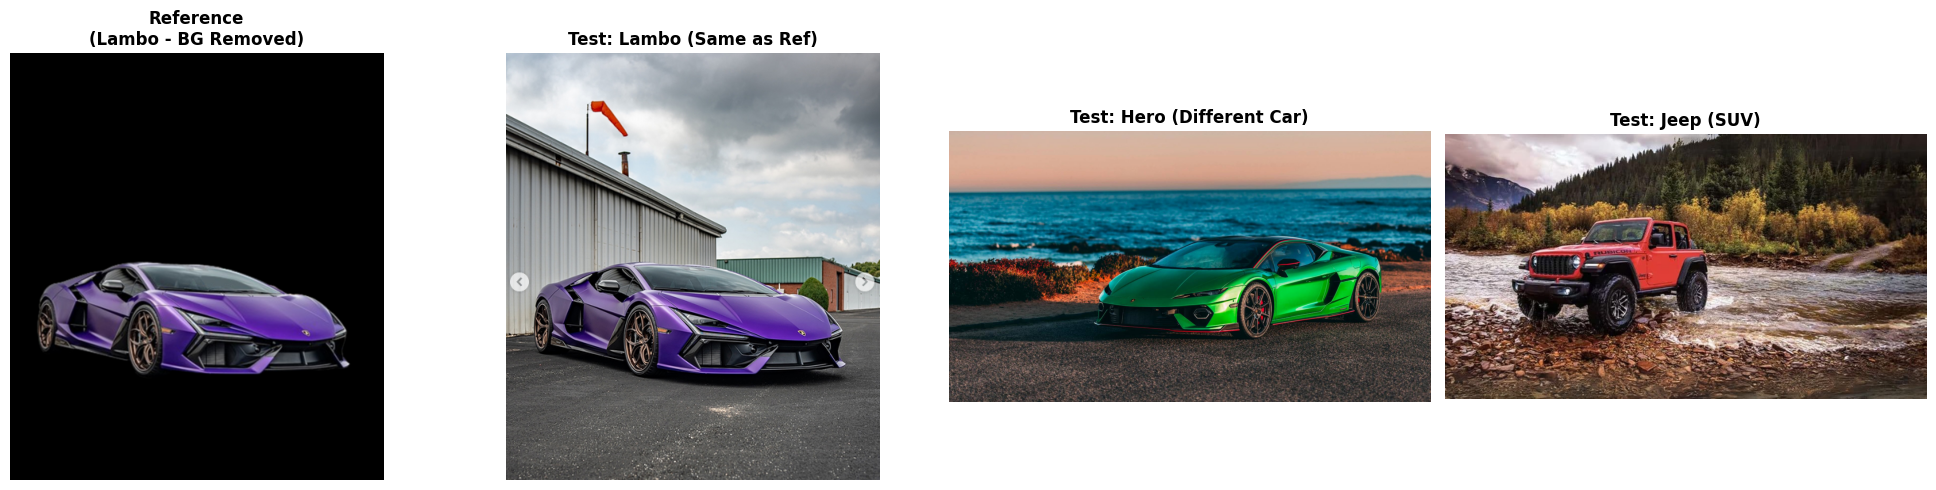


✓ Loaded 3 test images


In [382]:
# Load reference and all test images
ref_path = 'images/lambo_ref.png'
test_paths = [
    ('images/lambo.png', 'Lambo (Same as Ref)'),
    ('images/hero.jpg', 'Hero (Different Car)'),
    ('images/jeep.jpg', 'Jeep (SUV)')
]

# Check reference
if not os.path.exists(ref_path):
    print(f"❌ ERROR: {ref_path} not found!")
else:
    print(f"✓ Found {ref_path}")

# Check test images
test_images = []
for path, name in test_paths:
    if not os.path.exists(path):
        print(f"⚠ WARNING: {path} not found - skipping {name}")
    else:
        print(f"✓ Found {path}")
        img = Image.open(path).convert('RGB')
        test_images.append((img, name, path))

# Load reference
ref_img = Image.open(ref_path).convert('RGB')

# Display all images
fig, axes = plt.subplots(1, len(test_images) + 1, figsize=(5 * (len(test_images) + 1), 5))
axes[0].imshow(ref_img)
axes[0].set_title('Reference\n(Lambo - BG Removed)', fontweight='bold', fontsize=12)
axes[0].axis('off')

for idx, (img, name, _) in enumerate(test_images):
    axes[idx + 1].imshow(img)
    axes[idx + 1].set_title(f'Test: {name}', fontweight='bold', fontsize=12)
    axes[idx + 1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Loaded {len(test_images)} test images")


In [383]:
# Extract reference features
ref_tensor = t_dinov2(ref_img).unsqueeze(0).to(_target_device)
ref_global_feature = extract_global_feature(model, ref_tensor, _target_device)

print(f"✓ Reference features extracted: {ref_global_feature.shape}")


✓ Reference features extracted: torch.Size([1, 384])


In [384]:
# Check similarity statistics
print("Similarity map statistics:")
print(f"  Min: {similarity_map_without.min():.3f}")
print(f"  Max: {similarity_map_without.max():.3f}")
print(f"  Mean: {similarity_map_without.mean():.3f}")
print(f"  Median: {np.median(similarity_map_without):.3f}")
print(f"\nValues above threshold 0.2: {np.sum(similarity_map_without >= 0.2)}/{37*37} patches")

Similarity map statistics:
  Min: -0.208
  Max: 0.016
  Mean: -0.079
  Median: -0.074

Values above threshold 0.2: 0/1369 patches


In [385]:
# Process all test images
threshold = 0.1
results = []

for test_img, name, path in test_images:
    print("="*70)
    print(f"PROCESSING: {name}")
    print("="*70)
    
    # WITHOUT background removal
    test_tensor = t_dinov2(test_img).unsqueeze(0).to(_target_device)
    test_patch_features = extract_patch_features(model, test_tensor, _target_device)
    similarity_map_without = compute_similarity_map(ref_global_feature, test_patch_features)
    binary_mask_without = (similarity_map_without >= threshold).astype(np.float32)
    upscaled_mask_without = upscale_mask(binary_mask_without)
    
    # WITH background removal
    test_img_cleaned = apply_mask(test_img, upscaled_mask_without, background_color=(0, 0, 0))
    test_cleaned_tensor = t_dinov2(test_img_cleaned).unsqueeze(0).to(_target_device)
    test_cleaned_patch_features = extract_patch_features(model, test_cleaned_tensor, _target_device)
    similarity_map_with = compute_similarity_map(ref_global_feature, test_cleaned_patch_features)
    binary_mask_with = (similarity_map_with >= threshold).astype(np.float32)
    upscaled_mask_with = upscale_mask(binary_mask_with)
    
    # Store results
    results.append({
        'name': name,
        'img': test_img,
        'img_cleaned': test_img_cleaned,
        'mask_without': upscaled_mask_without,
        'mask_with': upscaled_mask_with,
        'similarity_without': similarity_map_without,
        'similarity_with': similarity_map_with,
        'coverage_without': upscaled_mask_without.mean() * 100,
        'coverage_with': upscaled_mask_with.mean() * 100
    })
    
    print(f"  Coverage WITHOUT: {upscaled_mask_without.mean()*100:.1f}%")
    print(f"  Coverage WITH:    {upscaled_mask_with.mean()*100:.1f}%")
    print()

print(f"✓ Processed {len(results)} images with threshold={threshold}")


PROCESSING: Lambo (Same as Ref)


  Coverage WITHOUT: 51.9%
  Coverage WITH:    92.2%

PROCESSING: Hero (Different Car)
  Coverage WITHOUT: 38.6%
  Coverage WITH:    79.0%

PROCESSING: Jeep (SUV)
  Coverage WITHOUT: 0.0%
  Coverage WITH:    0.0%

✓ Processed 3 images with threshold=0.1


COMPREHENSIVE COMPARISON


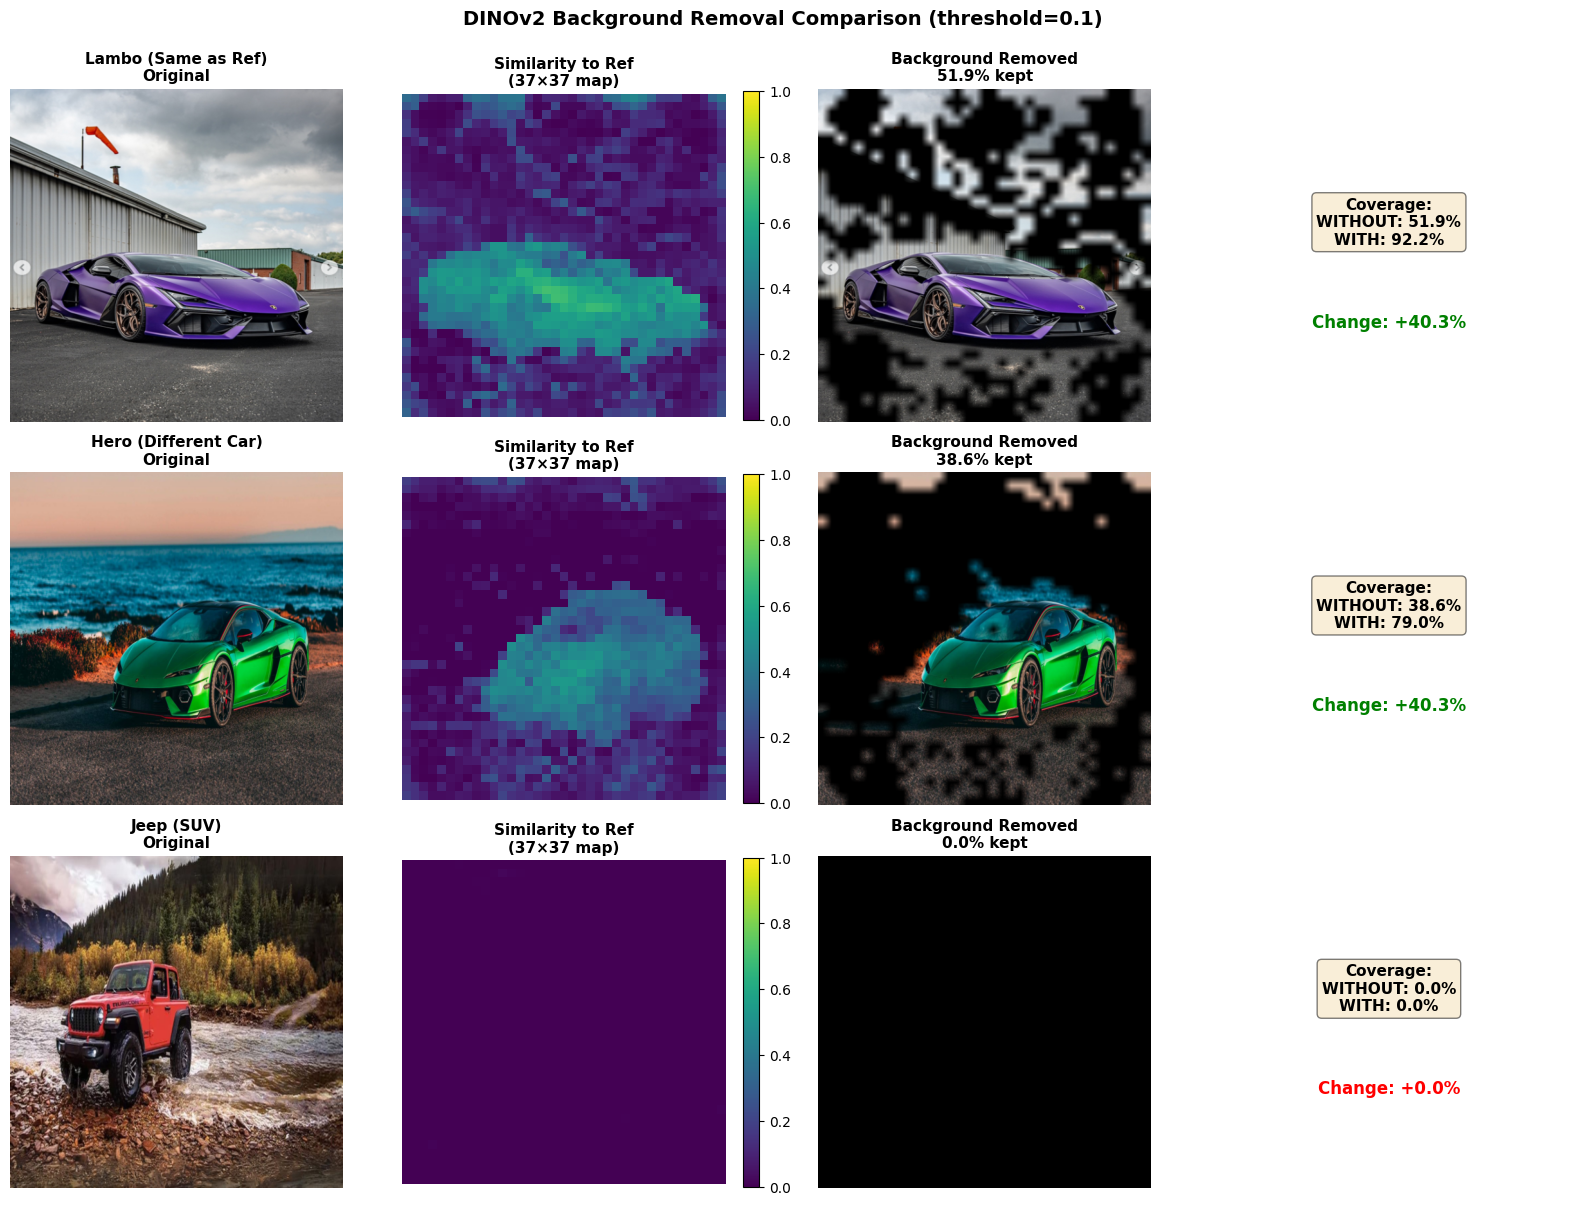

In [386]:
# VISUAL COMPARISON - All Images
print("="*70)
print("COMPREHENSIVE COMPARISON")
print("="*70)

fig, axes = plt.subplots(len(results), 4, figsize=(16, 4*len(results)))

if len(results) == 1:
    axes = axes.reshape(1, -1)

for idx, result in enumerate(results):
    # Column 1: Original
    img_resized = result['img'].resize((518, 518), Image.BILINEAR)
    axes[idx, 0].imshow(img_resized)
    axes[idx, 0].set_title(f"{result['name']}\nOriginal", fontweight='bold', fontsize=11)
    axes[idx, 0].axis('off')
    
    # Column 2: Similarity map
    im = axes[idx, 1].imshow(result['similarity_without'], cmap='viridis', vmin=0, vmax=1)
    axes[idx, 1].set_title(f"Similarity to Ref\n(37×37 map)", fontweight='bold', fontsize=11)
    axes[idx, 1].axis('off')
    plt.colorbar(im, ax=axes[idx, 1], fraction=0.046)
    
    # Column 3: Background removed
    img_cleaned_resized = result['img_cleaned'].resize((518, 518), Image.BILINEAR)
    axes[idx, 2].imshow(img_cleaned_resized)
    axes[idx, 2].set_title(f"Background Removed\n{result['coverage_without']:.1f}% kept", 
                          fontweight='bold', fontsize=11)
    axes[idx, 2].axis('off')
    
    # Column 4: Comparison
    improvement = result['coverage_with'] - result['coverage_without']
    color = 'green' if improvement > 0 else 'red'
    axes[idx, 3].text(0.5, 0.6, f"Coverage:\nWITHOUT: {result['coverage_without']:.1f}%\nWITH: {result['coverage_with']:.1f}%",
                     ha='center', va='center', fontsize=11, fontweight='bold',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[idx, 3].text(0.5, 0.3, f"Change: {improvement:+.1f}%",
                     ha='center', va='center', fontsize=12, fontweight='bold', color=color)
    axes[idx, 3].axis('off')

plt.suptitle(f'DINOv2 Background Removal Comparison (threshold={threshold})', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [387]:
# SUMMARY TABLE
print("="*70)
print("SUMMARY")
print("="*70)
print(f"Reference: Lambo (background manually removed)")
print(f"Detection Method: DINOv2 feature similarity (threshold={threshold})")
print()
print(f"{'Test Image':<25} {'WITHOUT BG':<15} {'WITH BG':<15} {'Change':<10} {'Result'}")
print("-"*70)

for result in results:
    change = result['coverage_with'] - result['coverage_without']
    symbol = "✓" if change > 0 else "✗"
    print(f"{result['name']:<25} {result['coverage_without']:>6.1f}% {result['coverage_with']:>13.1f}% {change:>13.1f}%    {symbol}")

print()
print("NOTE: This demonstrates DINOv2's object-specific matching.")
print("Expected behavior: Works best for similar objects (Lambo), worse for different ones (Jeep).")
print("="*70)


SUMMARY
Reference: Lambo (background manually removed)
Detection Method: DINOv2 feature similarity (threshold=0.1)

Test Image                WITHOUT BG      WITH BG         Change     Result
----------------------------------------------------------------------
Lambo (Same as Ref)         51.9%          92.2%          40.3%    ✓
Hero (Different Car)        38.6%          79.0%          40.3%    ✓
Jeep (SUV)                   0.0%           0.0%           0.0%    ✗

NOTE: This demonstrates DINOv2's object-specific matching.
Expected behavior: Works best for similar objects (Lambo), worse for different ones (Jeep).
